In [1]:
import pandas as pd

FILENAME = 'metrics_comparison_test.csv'


def print_df(df):
    # 'display.max_rows', None,
    with pd.option_context('display.max_columns', None, 'display.expand_frame_repr', False):
        print(df)


def get_metrics_df(filename):
    df = pd.read_csv(
        filename,
        sep=';',
        header=1,
        # index_col=0,
    )
    df.rename(columns={'Unnamed: 0': 'metrics'}, inplace=True)
    df.drop(columns=['optimal', 'miserable'], inplace=True)
    df.drop(index=df[df.metrics == 'SMAPE'].index, inplace=True)
    return df


df = get_metrics_df(FILENAME)
print_df(df)

        metrics   hgbr linreg     nn     gp   mvnn  qhgbr     qr cp_hgbr cp_linreg  cp_nn  la_nn
0           MAE  137,0  212,3  152,5  135,7  153,0  146,0  144,5   137,0     212,3  152,5  152,5
1          RMSE  182,2  283,4  197,2  179,5  197,5  193,4  188,0   182,2     283,4  197,2  197,2
3  SMAPE (x100)   1,07   1,68   1,19   1,04   1,20   1,13   1,12    1,07      1,68   1,19   1,19
4          CRPS    NaN    NaN    NaN   96,3  111,2   95,1  103,5    99,2     152,8  108,4  108,2
5           NLL    NaN    NaN    NaN   6,60   6,97   6,66   6,69    6,68      7,07   6,71   6,70
6       PINBALL    NaN    NaN    NaN   18,7   15,9   28,7   17,5    16,0      31,1   19,8   22,6
7           SSR    NaN    NaN    NaN   0,88   0,68   0,82   0,93    0,80      1,05   0,90   0,97


In [40]:
df2 = df.copy()
df2.index = metrics
df2.drop(columns='metrics', inplace=True)
df2.rename(index={'SMAPE (x100)': 'SMAPE_scaled'}, inplace=True)
df2.replace(r'(\d+),(\d+)', r'\1.\2', regex=True, inplace=True)  # convert to floats
df2 = df2.astype(float)
df2

,hgbr,linreg,nn,gp,mvnn,qhgbr,qr,cp_hgbr,cp_linreg,cp_nn,la_nn
metrics,,,,,,,,,,,
MAE,137.00,212.30,152.50,135.70,153.00,146.00,144.50,137.00,212.30,152.50,152.50
RMSE,182.20,283.40,197.20,179.50,197.50,193.40,188.00,182.20,283.40,197.20,197.20
SMAPE_scaled,1.07,1.68,1.19,1.04,1.20,1.13,1.12,1.07,1.68,1.19,1.19
CRPS,NaN,NaN,NaN,96.30,111.20,95.10,103.50,99.20,152.80,108.40,108.20
NLL,NaN,NaN,NaN,6.60,6.97,6.66,6.69,6.68,7.07,6.71,6.70
PINBALL,NaN,NaN,NaN,18.70,15.90,28.70,17.50,16.00,31.10,19.80,22.60
SSR,NaN,NaN,NaN,0.88,0.68,0.82,0.93,0.80,1.05,0.90,0.97


,hgbr,linreg,nn,gp,mvnn,qhgbr,qr,cp_hgbr,cp_linreg,cp_nn,la_nn
metrics,,,,,,,,,,,
MAE,137.0,212.3,152.5,135.7,153.0,146.0,144.5,137.0,212.3,152.5,152.5
RMSE,182.2,283.4,197.2,179.5,197.5,193.4,188.0,182.2,283.4,197.2,197.2
SMAPE_scaled,1.07,1.68,1.19,1.04,1.20,1.13,1.12,1.07,1.68,1.19,1.19
CRPS,NaN,NaN,NaN,96.3,111.2,95.1,103.5,99.2,152.8,108.4,108.2
NLL,NaN,NaN,NaN,6.60,6.97,6.66,6.69,6.68,7.07,6.71,6.70
PINBALL,NaN,NaN,NaN,18.7,15.9,28.7,17.5,16.0,31.1,19.8,22.6
SSR,NaN,NaN,NaN,0.88,0.68,0.82,0.93,0.80,1.05,0.90,0.97


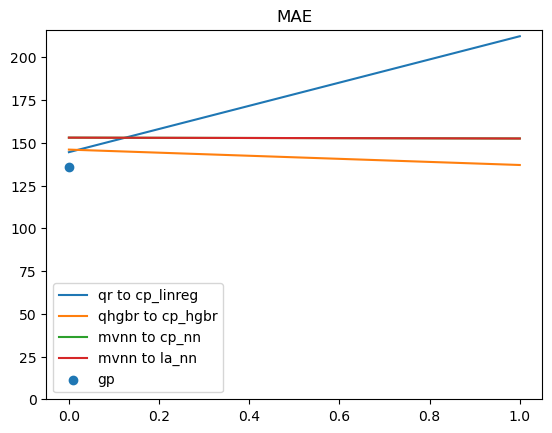

In [67]:
import matplotlib.pyplot as plt

def get_metric_value(df, metric, method):
    return df.loc[metric][method]

metrics = df2.index
pairs = [
    ['qr', 'cp_linreg'],
    ['qhgbr', 'cp_hgbr'],
    ['mvnn', 'cp_nn'],
    ['mvnn', 'la_nn'],
    ['gp', None],
]
metric = metrics[0]

fig, ax = plt.subplots()
x_plot = [0, 1]
methods, points = [], []
for pair in pairs:
    method1, method2 = pair
    if method2 is None:
        metric_value1 = get_metric_value(df2, metric, method1)
        ax.scatter(x_plot[:1], metric_value1, label=method1)
        points.append((x_plot[0], metric_value1))
        methods.append(method1)
        continue
    metrics_values = [get_metric_value(df2, metric, method) for method in pair]
    ax.plot(x_plot, metrics_values, label=f'{method1} to {method2}')
    points.extend(list(zip(x_plot, metrics_values)))
    methods.extend(pair)

x_shift = 0.1
x_lim_bot = x_plot[0] - 2*x_shift
x_lim_top = x_plot[1] + 2*x_shift 
# ax.set_xlim(x_lim_bot, x_lim_top)
ax.set_ylim(bottom=0)
# x_pos1 = x_plot[0] - x_shift
# x_pos2 = x_plot[1] + x_shift
# for point, method in zip(points, methods):
#     point_x, point_y = point
#     xytext = (x_pos1, point_y) if point_x == x_plot[0] else (x_pos2, point_y)
#     ax.annotate(method, xy=point, xytext=xytext)
ax.set_title(metric)
ax.legend()